### Business Analysis and Launch of A/B Testing: Targeting Untapped Market

### Insights Specific to Customers Aged 18–25

1. Customers aged **18–25 account for approximately 25%** of the total customer base, making them a significant but underutilized segment.
2. The **average annual income for this group is below 50,000**, indicating limited earning capacity and early career stages.
3. They have **limited credit history**, which is reflected in their relatively lower credit scores and reduced maximum credit limits.
4. **Credit card usage is comparatively low** for this age group, with a higher preference for UPI and debit card transactions.
5. The **average transaction amount made using credit cards is also lower** than that of other age groups, suggesting cautious spending behavior.
6. The **top three most frequently purchased product categories** for this segment are:
   - Electronics
   - Fashion & Apparel
   - Beauty & Personal Care

![Analysis Image](credit_analysis_dashboard.png)

## (1) Pre-Campaign

We want to perform a trial run for our new credit card initiative. Before launching the final campaign, we need to determine **how many customers are required for our A/B test**. This involves forming two groups:

- **Control Group** – receives no new offers
- **Test Group** – receives the new credit card campaign benefits

To ensure statistically valid and reliable results, we must calculate the **required sample size** for both groups. This sample size depends on:

1. **Statistical Power** – the probability of detecting a real effect (commonly set to 80% or 90%).
2. **Effect Size** – the minimum uplift or difference we want to detect, determined after discussions with business teams.
3. **Significance Level (α)** – typically set at 0.05.

Using these parameters, we compute the required number of customers per group to ensure the experiment is properly powered and capable of detecting meaningful differences.

In [32]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_loader import DataLoader

In [33]:
alpha = 0.05
power = 0.8
effect_size =0.2
effect_sizes= [0.1,0.2,0.3,0.4,0.5,1]

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power,
        ratio=1,
        alternative="two-sided",
    )
    print(f"effect_size = {effect_size}, sample_size = {sample_size:.0f}")

effect_size = 0.1, sample_size = 1571
effect_size = 0.2, sample_size = 393
effect_size = 0.3, sample_size = 175
effect_size = 0.4, sample_size = 99
effect_size = 0.5, sample_size = 64
effect_size = 1, sample_size = 17


#### Forming Control and Test Groups

1. We identified approximately **246 customers** within the age group of 18–25. From this total pool, **100 customers were selected** for the initial test campaign.

2. The campaign was launched for these **100 customers**, based on the effect size calculation and business budgeting constraints. The campaign duration was set to **2 months**.

3. The campaign achieved a **conversion rate of ~40%**, meaning **40 out of 100** customers in the test group started using the credit card.

4. To maintain a comparable sample size for analysis, a **control group of 40 customers** was created. This control group is **entirely exclusive** and does not overlap with the initial 100 customers in the test group.

5. As a result, we now have **40 customers in the control group** and **40 customers in the test group**, ensuring balanced comparison for statistical testing.

6. Based on business requirements, the test should be capable of detecting a **minimum 0.4 standard deviation difference** between the two groups. For an effect size of **0.4**, the required sample size is approximately **100 customers**. After discussion with business stakeholders, this sample size was approved considering both feasibility and budgeting constraints for the trial run.

In [34]:
loader = DataLoader()
df = loader.load_table("avg_transactions_after_campaign")

df.head()

avg_transactions_after_campaign loaded successfully. shape: (62, 3)


,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,251.02,401.78
1,2023-09-11,250.77,326.16
2,2023-09-12,248.81,303.92
3,2023-09-13,255.90,363.29
4,2023-09-14,255.86,317.06


## (2) Post-Campaign

After completing the 2-month campaign, we collected the post-campaign transaction data for both the control and test groups.

- The dataset **avg_transactions_after_campaign** contains **62 rows and 3 columns**.
- The three columns in the dataset are:
  - `campaign_date`
  - `control_group_avg_tran`
  - `test_group_avg_tran`

The **minimum and maximum campaign dates** in the dataset are:

- **Start Date:** 2023-09-10
- **End Date:** 2023-11-10

This dataset will be used to compare the average daily transaction trends between the control and test groups and to evaluate the impact of the campaign.

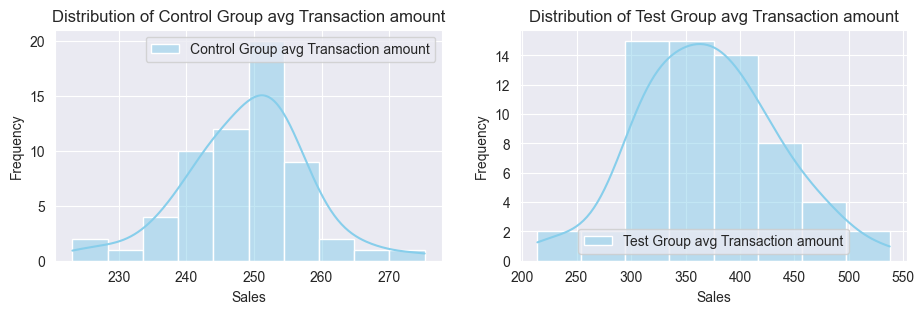

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

sns.histplot(df["control_group_avg_tran"], kde=True, color = "skyblue", label="Control Group avg Transaction amount", ax=ax1)
ax1.set_xlabel("Sales")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Control Group avg Transaction amount")
ax1.legend()

sns.histplot(df["test_group_avg_tran"], kde=True, color = "skyblue", label="Test Group avg Transaction amount", ax=ax2)
ax2.set_xlabel("Sales")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Test Group avg Transaction amount")
ax2.legend()
plt.show()

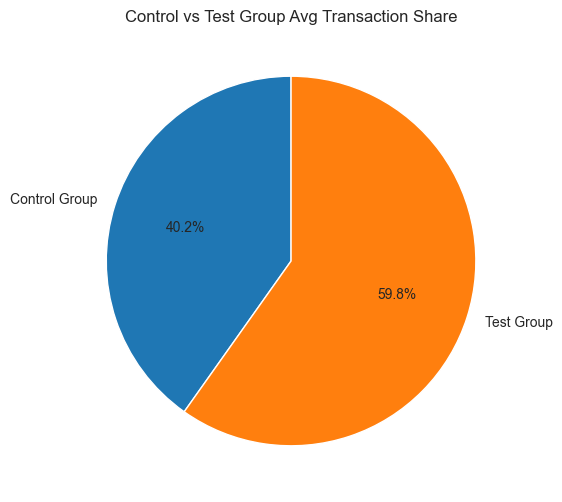

In [36]:
values = [
    df["control_group_avg_tran"].sum(),
    df["test_group_avg_tran"].sum()
]
labels = ["Control Group", "Test Group"]

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Control vs Test Group Avg Transaction Share")
plt.show()

In [37]:
df[df.control_group_avg_tran > df.test_group_avg_tran].shape

(2, 3)

In [38]:
df[df["test_group_avg_tran"] > df["control_group_avg_tran"]].shape

(60, 3)

### Z-Test Formula

The Z-statistic for comparing two independent group means is:

$$Z = \frac{\bar{X}_{\text{test}} - \bar{X}_{\text{control}}}{\sqrt{\frac{\sigma_{\text{test}}^{2}}{n} + \frac{\sigma_{\text{control}}^{2}}{n}}}$$

**Where:**

*   $\bar{X}_{\text{test}}$: Mean of the test group
*   $\bar{X}_{\text{control}}$: Mean of the control group
*   $\sigma_{\text{test}}$: Standard deviation of the test group
*   $\sigma_{\text{control}}$: Standard deviation of the control group
*   $n$: Sample size in each group

The formula calculates how many **standard errors** separate the difference in means from zero. A larger Z-value indicates a stronger effect of the campaign.

In [39]:
control_mean = df["control_group_avg_tran"].mean()
control_std = df["control_group_avg_tran"].std()

test_mean = df["test_group_avg_tran"].mean()
test_std = df["test_group_avg_tran"].std()

sample = df.shape[0]
control_mean, control_std, test_mean, test_std, sample

(np.float64(248.94129032258064),
 np.float64(9.137869049553624),
 np.float64(370.5364516129033),
 np.float64(63.25415113953286),
 62)

In [40]:
a = test_std**2/sample
b = control_std**2/sample

z_score = (test_mean - control_mean)/np.sqrt(a+b)
z_score

np.float64(14.98090307099052)

In [41]:
critical_z_value = st.norm.ppf(1-alpha)
critical_z_value

np.float64(1.6448536269514722)

In [42]:
z_score > critical_z_value

np.True_

### Hypothesis Test Results

**Statistical Summary:**
*   **Calculated Z-Score:** $14.981$
*   **Critical Z-Value:** $1.645$ (at $\alpha = 0.05$)
*   **Test Result:** $Z_{score} > Z_{critical}$ is **True**

---

### Final Conclusion

Based on the statistical analysis, we **reject the null hypothesis ($H_0$)**.

**Interpretation:**
The difference between the test and control group means is statistically significant. The test group's performance is approximately **14.98 standard errors** above the control group, which far exceeds the threshold required for a 95% confidence level.

We can conclude with high confidence that the changes implemented in the test group had a **positive and significant effect** compared to the control.